In [4]:
# Built-in libraries
import os
import re
import time
from datetime import datetime
import pytz
from itertools import compress
from math import log
from math import log2
import random

# NumPy, SciPy and Pandas
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import iqr
import pandas as pd

# Scikit-Learn
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import sqeuclidean
from sklearn.neighbors import NearestNeighbors

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
%matplotlib inline

# JoyPy
import joypy

# Workalendar
from workalendar.europe import Switzerland
from workalendar.europe import UnitedKingdom
from workalendar.usa import Colorado
from workalendar.usa import NewYork
from workalendar.usa import California
from workalendar.usa import Arizona
from workalendar.usa import Illinois
from workalendar.asia import Singapore
from workalendar.oceania import WesternAustralia

In [5]:
combined_profiles = pd.read_csv('final_profiles.csv')

/Users/yangxiya/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Generate building

In [7]:
def get_proportions(pd_labels):
    result = {}
    vals = pd_labels.value_counts()
    total = pd_labels.shape[0]
    for i in vals.index:
        result[i] = (vals.loc[i]/total)
    result['count'] = total
    return result

def get_list_of_proportions(profiles):
    return profiles.groupby('Building')[['cluster']].transform(get_proportions)

In [106]:
def get_dominant_clusters(proportions_mat):
    dominant_flag = np.max(proportions_mat, axis=1) > .5
    dominant_clusters = np.argmax(proportions_mat, axis=1)
    dominant_clusters[~dominant_flag] = -1
    return dominant_clusters

In [107]:
def build_df(profiles, k, algo, labels_dir):
    profiles['cluster'] = np.load('./%s/%s/params[k=%d].npy' % (labels_dir, algo, k))
    profiles['proportions'] = get_list_of_proportions(profiles)
    
    final_buildings = profiles.drop_duplicates(['Dataset', 'Building'])[['Dataset', 'Building', 'proportions', 'Industry', 'PSU', 'Sqm', 'Subindustry', 'Timezone', 'EUI', 'Climatezone', 'EUI Binned', 'Sqm Binned']]
    final_buildings.reset_index(drop=True, inplace=True)
    
    filtered_buildings = final_buildings.loc[final_buildings.proportions.map(lambda x: x['count']) >= 30, :]
    filtered_buildings.reset_index(drop=True, inplace=True)
    
    cluster_labels = profiles.cluster.unique()
    cluster_labels.sort()
    
    proportions_data = []

    for dic in filtered_buildings.proportions.tolist():
        proportions_data.append([])
        for label in cluster_labels:
            if label not in dic:
                proportions_data[-1].append(0)
            else:
                proportions_data[-1].append(dic[label])

    proportions_df = pd.DataFrame(proportions_data)
    
    buildings_df = filtered_buildings.drop('proportions', axis=1)
    buildings_df['dominant_cluster'] = get_dominant_clusters(proportions_df.as_matrix())
    return (buildings_df, proportions_df)

In [108]:
buildings, proportions = build_df(combined_profiles, 3, 'kmeans', 'final_labels')

In [112]:
buildings.head()

,Dataset,Building,Industry,PSU,Sqm,Subindustry,Timezone,EUI,Climatezone,EUI Binned,Sqm Binned,dominant_cluster
0,pecan,3831,Residential,Single_family_house,105.909466,NaN,America/Chicago,45.627032,2,"(0, 1186.001]","(0, 33585.359]",2
1,pecan,3938,Residential,Single_family_house,104.051405,NaN,America/Chicago,20.858344,2,"(0, 1186.001]","(0, 33585.359]",2
2,pecan,5371,Residential,Single_family_house,87.050148,NaN,America/Chicago,91.462989,2,"(0, 1186.001]","(0, 33585.359]",2
3,pecan,9775,Residential,Single_family_house,130.528771,NaN,America/Chicago,40.263767,2,"(0, 1186.001]","(0, 33585.359]",2
4,pecan,5218,Residential,Single_family_house,193.145420,NaN,America/Chicago,35.506750,2,"(0, 1186.001]","(0, 33585.359]",2


### Binning
* Buildings with EUIs in the 1st, 2nd and 3rd percentiles make up 88% of all buildings
* We only use these buildings for producing the benchmarking plots

In [113]:
def rebuild_intervals(series):
    results = []
    for interval in series:
        results.append(pd.Interval(max(0, interval.left), interval.right))
    return pd.Series(results)

In [114]:
buildings['EUI Binned'] = rebuild_intervals(pd.cut(buildings.EUI, 1000))

In [115]:
fourth_percentile = sorted(buildings['EUI Binned'].unique().tolist())[3]
filter_values = [interval < fourth_percentile for interval in buildings['EUI Binned']]
filtered_buildings = buildings.copy().loc[filter_values, :].drop('Sqm Binned', axis=1)

In [116]:
filtered_buildings.head()

,Dataset,Building,Industry,PSU,Sqm,Subindustry,Timezone,EUI,Climatezone,EUI Binned,dominant_cluster
78,pecan,8342,Residential,Single_family_house,126.812650,NaN,America/Chicago,16.421075,2,"(13.044, 18.968]",2
85,pecan,5909,Residential,Single_family_house,66.890189,NaN,America/Chicago,14.712612,2,"(13.044, 18.968]",-1
237,MIT,M26C,Education,College Laboratory,12400.697779,College/University,America/New_York,2.920461,5,"(0, 7.12]",-1
247,MIT,M13D,Education,College Classroom,17040.925918,College/University,America/New_York,7.368155,5,"(7.12, 13.044]",1
249,MIT,M50A,Education,Others,6880.770755,College/University,America/New_York,6.879539,5,"(0, 7.12]",1


In [117]:
buildings_sample = filtered_buildings.sample(100, random_state=42)

In [118]:
buildings_sample.head()

,Dataset,Building,Industry,PSU,Sqm,Subindustry,Timezone,EUI,Climatezone,EUI Binned,dominant_cluster
697,ireland,3382,Residential,Single_family_house,139.354560,NaN,Europe/London,18.738389,4,"(13.044, 18.968]",2
1891,ireland,6499,Residential,Single_family_house,102.193344,NaN,Europe/London,18.040705,4,"(13.044, 18.968]",2
1387,ireland,6750,Residential,Single_family_house,102.193344,NaN,Europe/London,7.225911,4,"(7.12, 13.044]",2
2133,genome,PrimClass_Eoghan,Education,Primary/Secondary Classroom,29301.990428,Primary/Secondary School,America/New_York,4.409430,4,"(0, 7.12]",0
2990,genome2,RisleyHall.Elec.PowerScout3.kWsystem,Education,Dormitory,8949.907261,College/University,America/New_York,18.887863,4,"(13.044, 18.968]",0


In [119]:
buildings_sample['EUI Binned'].value_counts()

(0.0, 7.12]         45
(7.12, 13.044]      32
(13.044, 18.968]    23
Name: EUI Binned, dtype: int64

In [120]:
buildings_sample['Dataset'].value_counts()

ireland       49
genome2       30
genome        14
washington     6
MIT            1
Name: Dataset, dtype: int64

In [121]:
buildings_sample['PSU'].value_counts()

Single_family_house            49
Primary/Secondary Classroom    22
Office                         10
Others                          8
Retail                          5
Gymnasium                       2
Industrial                      1
Dormitory                       1
College Laboratory              1
College Classroom               1
Name: PSU, dtype: int64

### Rename PSUs with only 1 building to Others

In [122]:
psu_counts = buildings_sample['PSU'].value_counts()
conversion_set = psu_counts.index[psu_counts == 1]
conversion_flags = buildings_sample['PSU'].isin(conversion_set).tolist()
new_PSUs = ['Others' if conversion_flags[i] else buildings_sample['PSU'].iloc[i] for i in range(buildings_sample.shape[0])]
buildings_sample['PSU'] = new_PSUs

/Users/yangxiya/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


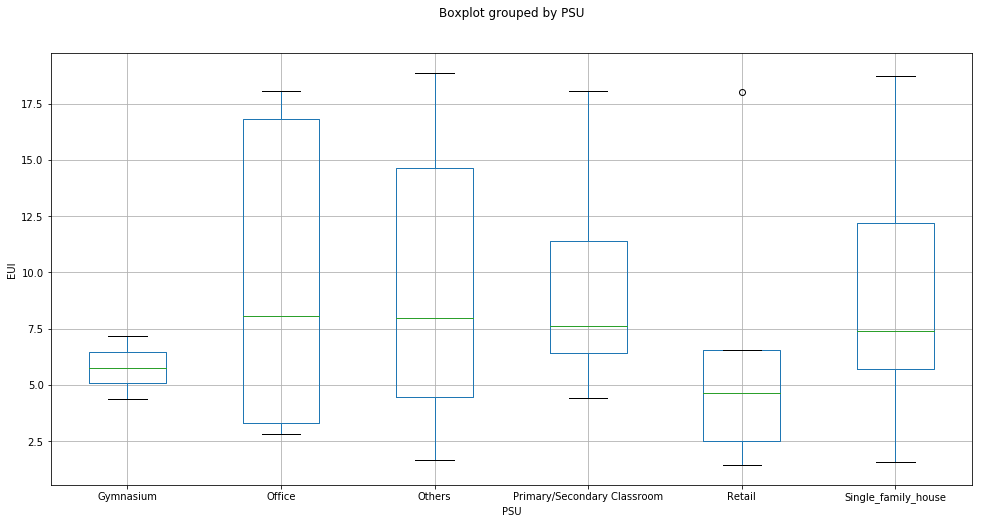

In [123]:
buildings_sample.boxplot('EUI', 'PSU', figsize=(16,8))
plt.title('')
plt.ylabel('EUI')
plt.show()
plt.close()

/Users/yangxiya/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


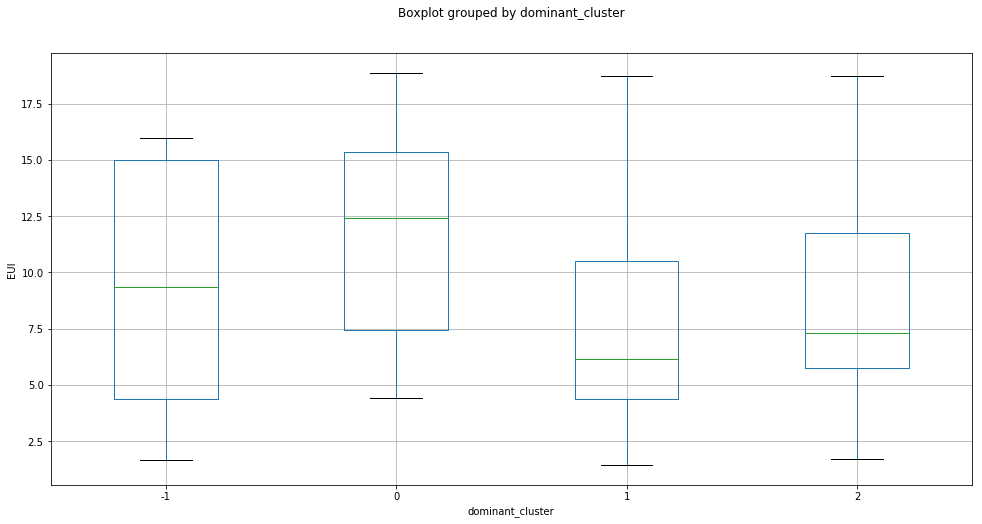

In [124]:
buildings_sample.boxplot('EUI', 'dominant_cluster', figsize=(16,8))
plt.title('')
plt.ylabel('EUI')
plt.show()
plt.close()

### Load-shape-based Bechmarking

In [225]:
def get_buildings_by_field(buildings, field, value):
    return buildings.loc[buildings[field] == value, ['Dataset', 'Building']]

In [226]:
def get_profiles(profiles, buildings):
    profiles_mat = profiles.as_matrix()
    buildings_mat = buildings.as_matrix()

    buildings_signatures = set([(row[0], row[1]) for row in buildings_mat])
    profiles_flags = [(row[0], row[1]) in buildings_signatures for row in profiles_mat]

    return profiles.loc[profiles_flags, :]

In [227]:
def get_quantile(profiles, quantile=0.5):
    return profiles.iloc[:, 3:3+24].quantile(quantile)

In [234]:
def plot_profiles(middle, upper, lower, value, save_dir):
    plt.figure(figsize=(16,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(middle, c=(1,0,0), label='Average Profile (%s)' % value)
    plt.plot(upper, '--', c=(0,0,0), label='75% Percentile')
    plt.plot(lower, '--', c=(0,0,0), label='25% Percentile')
    plt.xlabel('Time (h)')
    plt.ylabel('Normalized Energy Readings')
    plt.legend()
    if type(value) is str:
        plt.savefig(save_dir + '/Benchmarking Plot (%s)' % value, bbox_inches='tight')
    else:
        plt.savefig(save_dir + '/Benchmarking Plot (%d)' % value, bbox_inches='tight')
    plt.close()

* EUI Type

In [229]:
interval_dict = {}
intervals = sorted(buildings_sample['EUI Binned'].unique())
interval_dict[intervals[0]] = 'Low'
interval_dict[intervals[1]] = 'Medium'
interval_dict[intervals[2]] = 'High'

In [230]:
buildings_sample['EUI Type'] = [interval_dict[interval] for interval in buildings_sample['EUI Binned']]

In [239]:
buildings_sample['dominant_cluster + EUI Type'] = ['%s/%s' % (row['EUI Type'], row.dominant_cluster) for i, row in buildings_sample.iterrows()]

In [ ]:
plot_root = './benchmarking_plots'
fields = ['dominant_cluster', 'EUI Type', 'dominant_cluster + EUI Type']
for field in fields:
    save_dir = '%s/%s' % (plot_root, field)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for value in sorted(buildings_sample[field].unique()):
        profiles = get_profiles(combined_profiles, get_buildings_by_field(buildings_sample, field, value))
        lower = get_quantile(profiles, quantile=0.25)
        middle = get_quantile(profiles, quantile=0.5)
        upper = get_quantile(profiles, quantile=0.75)
        plot_profiles(middle, upper, lower, value, save_dir)